# Module : Apprentissage Autmatique et Réseaux de Neurones
 ## Projet : Implémentation  d'un détecteur de spam

### Réalisé par :
     - LAMINI Narimene 181831043933
     - GUETTAF Sarah 181831043933
###### Section : MASTER 1 SII    - Groupe : 04

# Importation des librairies necessaires au travail

In [32]:
import re
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import classification_report
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
 from sklearn.metrics import roc_curve, auc

# Étape 1 : Préparation des données
Dans cette étape, nous allons nettoyer nos e-mails avant de commencer la classification. pour ce faire, nous devrions:
- Transformer toutes les lettre de l-email en minscule
- Supprimer toutes les balises HTML
- Normaliser toutes les URLs en les remplaçant par le texte "httpaddr"
- Normaliser toutes les adresses email en les remplaçant par le texte "emailaddr"
- Normaliser tous les nombres en les remplaçant par le texte "number" 
- Normaliser tous les signe de dollar en les remplaçant par le texte "dollar" 
- Radicaliser les mots
- Supprimer les non-mots


Pour montrer ce processus de nettoyage, nous allons prendre l'exemple de l'email donné dans l'ennoncé du projet


## 1.1 Lecture de l'email

In [33]:
with open('emailSample1.txt', 'r') as email:
    file_contents = email.read()

file_contents

"> Anyone knows how much it costs to host a web portal ?\n>\nWell, it depends on how many visitors you're expecting.\nThis can be anywhere from less than 10 bucks a month to a couple of $100. \nYou should checkout http://www.rackspace.com/ or perhaps Amazon EC2 \nif youre running something big..\n\nTo unsubscribe yourself from this mailing list, send an email to:\ngroupname-unsubscribe@egroups.com"

## 1.2 Création du dictionnaire des mots de l'email

In [34]:
# cette fonction lit la liste des vocabulaire "vocabList" et la stock dans un dictionnaire
def getVocabList():
    with open('vocab.txt', 'r') as vocab:
        #sauvegarder tous les mots dans un dictionaire "vocabList"
        vocabList = {}
        for line in vocab.readlines():
            i, word = line.split()
            vocabList[word] = int(i)
    return vocabList

## 1.3 Prétraitement de l'email
Cette fonction prétraite le corps d'un email

In [35]:
def processEmail(email_contents):
   
    vocabList = getVocabList()

    # Initialiser un tableau des indices des mots de l'email
    word_indices = []
    
    # prétraitement de l'email
    #Transformer toutes les lettre de l-email en minscule
    email_contents = email_contents.lower()

    #Supprimer toutes les balises HTML
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)

    #Normaliser tous les nombres en les remplaçant par le texte "number" 
    email_contents = re.sub('[0-9]+', 'number', email_contents)

    # Normaliser toutes les URLs en les remplaçant par le texte "httpaddr"
    email_contents = re.sub('(http|https)://[^\s]*', 'httpaddr', email_contents)

    # Normaliser toutes les adresses email en les remplaçant par le texte "emailaddr"
    email_contents = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_contents)

    # Normaliser tous les signes de dollar en les remplaçant par le texte "dollar" 
    email_contents = re.sub('[$]+', 'dollar', email_contents)

    # Affichage de l'email
    print('\nEmail aprèes le prétraitement\n')

    # Process file
    l = 0
    email_contents = email_contents.translate(str.maketrans('', '', punctuation))

    # faire diviser l'email en mots séparés
    email_contents = email_contents.split()

    for token in email_contents:

        # supprimer les caractères non numériques
        token = re.sub('[^a-zA-Z0-9]', '', token)
        stemmer = SnowballStemmer("english")
        token = stemmer.stem(token.strip())
        if len(token) < 1:
           continue
        
 #vérifier l'existance du mot dans le dictionnaire et l'ajouter à la liste word_indices s'il existe 
        
        if token in vocabList:
            idx = vocabList[token]
            word_indices.append(idx)

        # Print to screen, ensuring that the output lines are not too long.
        if l + len(token) + 1 > 78:
            print()
            l = 0
        print(token, end=' ')
        l = l + len(token) + 1

    return word_indices

## 1.4 Affichage de l'email après prétraitement

In [36]:
word_indices = processEmail(file_contents)


Email aprèes le prétraitement

anyon know how much it cost to host a web portal well it depend on how mani 
visitor your expect this can be anywher from less than number buck a month to 
a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if 
your run someth big to unsubscrib yourself from this mail list send an email 
to emailaddr 

In [37]:
print('\n\nLes Indices des mots de l email: \n')
print(word_indices,"\n\n")



Les Indices des mots de l email: 

[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1895, 592, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 992, 961, 1477, 71, 530, 1699, 531] 




# Étape 2 : Classification
Dans cette étape, nous allons étudier tous les classifieurs appris durant ce semestre, notamment :
- La regression linéaire
- La regression logistique
- Les réseaux de neurones
- Machine à vecteurs de support
- L'algorithme des k moyennes
- L'algorithme des k plus proches voisins
- Bayes naif

Nous allons de plus exploiter d'autres classifieurs qui ne sont pas appris durant ce semsetre, tel que:
- Les arbres de descision
- La foret aléatoire


### Lecture de données d'entrainement et de test

In [38]:
# Lecture du dataset des emails d'entrainement, spamTrain
email_train = loadmat('spamTrain.mat')
X = email_train["X"]
y = email_train["y"]
y = y.ravel()

In [39]:
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X shape =  (4000, 1899)
y shape =  (4000,)


In [40]:
# Lecture du dataset des emails de test, spamTest
email_test = loadmat('spamTest.mat')
Xtest = email_test["Xtest"]
ytest = email_test["ytest"]
ytest = ytest.ravel()

In [41]:
print("Xtest shape = ",Xtest.shape)
print("ytest shape = ",ytest.shape)

Xtest shape =  (1000, 1899)
ytest shape =  (1000,)


### Affichafe des statistiques

In [42]:
def stat(model,p1,p2):
    print("\n============Classification report===========\n")
    print(classification_report(y, p1))
    print("\n============================================\n")
    print('Test Accuracy: {0:.2f}%'.format(np.mean((p2 == ytest).astype(int)) * 100))
    print("\n===============Confusion matrix==============\n")
    plot_confusion_matrix(model,Xtest,ytest)
    plt.show()
    

In [43]:
#cette fonction est utilisée pour l'algorithme des k moyennes
def statClustering(p1,p2):
    print("\n============Classification report===========\n")
    print(classification_report(y, p1))
    print("\n============================================\n")
    print('Test Accuracy: {0:.2f}%'.format(np.mean((p2 == ytest).astype(int)) * 100))
   

### La courbe ROC

In [56]:
#la courbe ROC
def ROCcurve(y_test,y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test,y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()

## Classifieur 01 : La Regression Linéaire (Linear Regression)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
model = LinearRegression()
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
print('Test Accuracy: {0:.2f}%'.format(np.mean((p2 == ytest).astype(int)) * 100))


Test Accuracy: 0.00%


## Classifieur 02 : La Regression logistique (Logistic Regression)


============Classification report===========

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2723
           1       1.00      1.00      1.00      1277

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



Test Accuracy: 99.40%

===============Confusion matrix==============



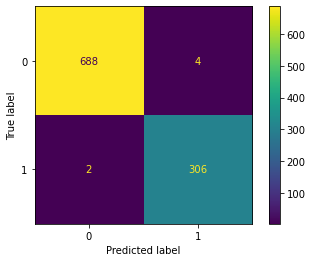

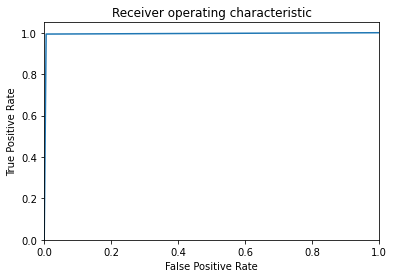

In [57]:
from sklearn.linear_model import LogisticRegression 
model = LogisticRegression()
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
stat(model,p1,p2) 
ROCcurve(ytest,p2)

## Classifieur 03 :Les réseaux de neurones


============Classification report===========

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2723
           1       1.00      1.00      1.00      1277

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



Test Accuracy: 98.60%

===============Confusion matrix==============



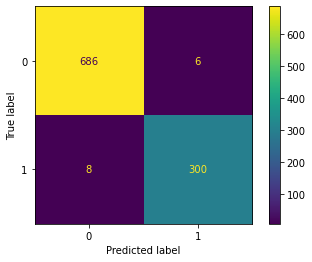

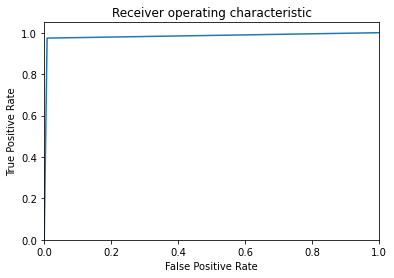

In [58]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
stat(model,p1,p2)
ROCcurve(ytest,p2)

## Classifieur 04 :Machine à vecteurs de support

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass C=0.25, kernel=linear as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



============Classification report===========

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2723
           1       1.00      1.00      1.00      1277

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



Test Accuracy: 98.20%

===============Confusion matrix==============



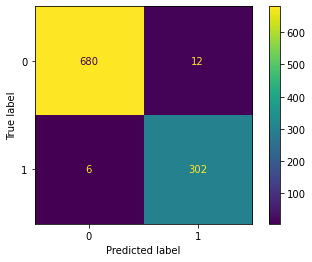

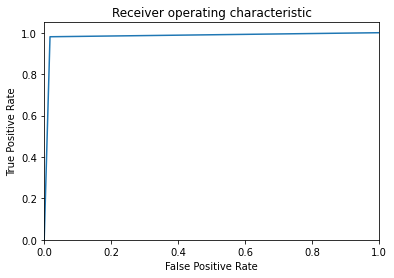

In [59]:
from sklearn import svm
C = 0.25
model = svm.SVC(C, 'linear')
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
stat(model,p1,p2)
ROCcurve(ytest,p2)

## Classifieur 05 : L'algorithme k moyennes


============Classification report===========

              precision    recall  f1-score   support

           0       0.60      0.15      0.24      2723
           1       0.30      0.79      0.44      1277

    accuracy                           0.35      4000
   macro avg       0.45      0.47      0.34      4000
weighted avg       0.50      0.35      0.30      4000



Test Accuracy: 34.50%


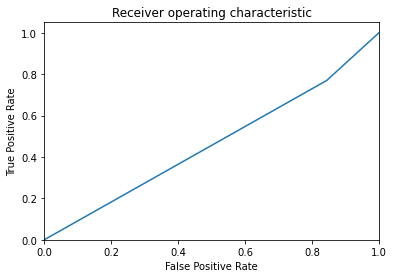

In [60]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0)
p1 = model.fit(X).predict(X)
p2 = model.predict(Xtest)
statClustering(p1,p2)
ROCcurve(ytest,p2)


## Classifieur 06 : L'algorithme des k plus proches voisins


============Classification report===========

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      2723
           1       0.86      0.98      0.91      1277

    accuracy                           0.94      4000
   macro avg       0.92      0.95      0.93      4000
weighted avg       0.95      0.94      0.94      4000



Test Accuracy: 89.70%

===============Confusion matrix==============



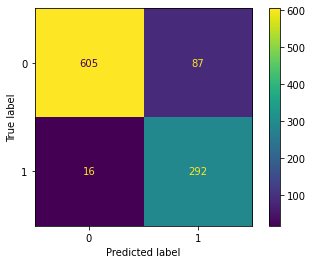

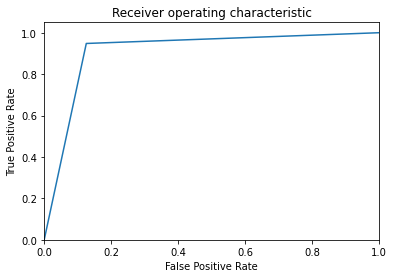

In [61]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
stat(model,p1,p2)
ROCcurve(ytest,p2)

## Classifieur 07 : Les arbres de descision


============Classification report===========

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2723
           1       0.90      0.87      0.89      1277

    accuracy                           0.93      4000
   macro avg       0.92      0.91      0.92      4000
weighted avg       0.93      0.93      0.93      4000



Test Accuracy: 92.00%

===============Confusion matrix==============



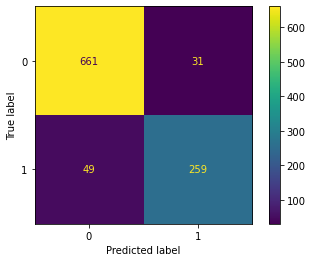

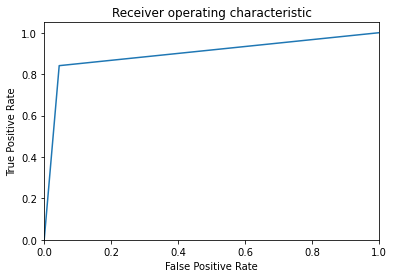

In [62]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0, max_depth=5)
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
stat(model,p1,p2)
ROCcurve(ytest,p2)

## Classifieur 08 : La foret aléatoire


============Classification report===========

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      2723
           1       0.98      0.58      0.73      1277

    accuracy                           0.86      4000
   macro avg       0.91      0.79      0.82      4000
weighted avg       0.88      0.86      0.85      4000



Test Accuracy: 87.00%

===============Confusion matrix==============



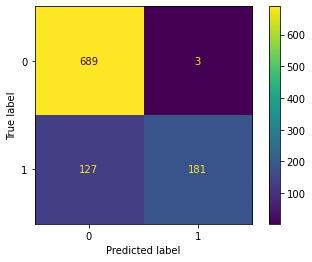

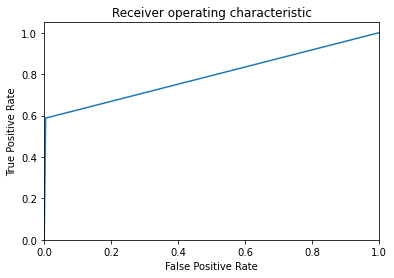

In [63]:
 from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=4, random_state=0)
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
stat(model,p1,p2)
ROCcurve(ytest,p2)

## Classifieur 09 : Bayes naif


============Classification report===========

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      2723
           1       0.69      0.99      0.81      1277

    accuracy                           0.85      4000
   macro avg       0.84      0.89      0.85      4000
weighted avg       0.90      0.85      0.86      4000



Test Accuracy: 87.20%

===============Confusion matrix==============



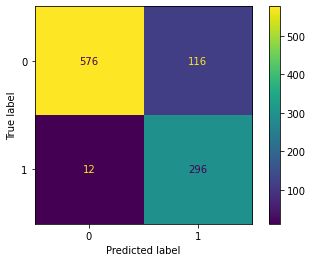

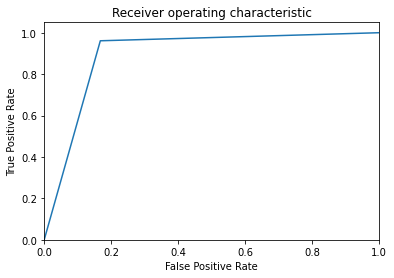

In [64]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
p1 = model.fit(X,y).predict(X)
p2 = model.predict(Xtest)
stat(model,p1,p2)
ROCcurve(ytest,p2)